In [3]:
# Number of data points to plot in each axis
num_points = 10

ggap_actual = 1.0
ggap_lo = 0.5
ggap_hi = 1.5

gsyn_actual = 1.0
gsyn_lo = 0.5
gsyn_hi = 1.5

C_actual = 0.015
gc_actual = 0.1

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from neural_model import NeuralModel
from simulation_functions import *
from sklearn.decomposition import PCA
from util.analysis_util import *
from util.neuron_metadata import *
from util.plot_util import *

ggap_vals = []
gsyn_vals = []
dom_amplitude_vals = []
dom_amplitude_convergence_vals = []
dom_period_vals = []
dimensionality_vals = []

i = 0
for gsyn in np.linspace(gsyn_lo, gsyn_hi, num_points):
  for ggap in np.linspace(ggap_lo, ggap_hi, num_points):
    i += 1
    start_time = time.time()
    fwd_dynamics = simulate_until_stable(C_actual, gc_actual, ggap, gsyn)
    elapsed_time = time.time() - start_time
    print("Iteration {0}/{1} took {2:.2f}s".format(i, num_points ** 2, elapsed_time))

    n = fwd_dynamics.shape[0]
    X = fwd_dynamics - fwd_dynamics.mean(axis = 0)
    pca = PCA()
    projected_X = pca.fit_transform(fwd_dynamics)
    dom_mode = projected_X[:,0]
    dom_amplitude = get_amplitude(dom_mode)
    dom_amplitude_convergence = get_amplitude_convergence(dom_mode)
    dom_period = get_period(dom_mode)
    eigen_vals = get_eigenvalues_from_pca(pca, n)
    dimensionality = get_dimensionality(eigen_vals)

    ggap_vals.append(ggap)
    gsyn_vals.append(gsyn)
    dom_amplitude_vals.append(dom_amplitude)
    dom_amplitude_convergence_vals.append(dom_amplitude_convergence)
    dom_period_vals.append(dom_period)
    dimensionality_vals.append(dimensionality)

Iteration 1/100 took 2.93s
Iteration 2/100 took 2.54s
Iteration 3/100 took 2.25s
Iteration 4/100 took 2.02s
Iteration 5/100 took 1.84s
Iteration 6/100 took 1.80s
Iteration 7/100 took 1.62s
Iteration 8/100 took 1.61s
Iteration 9/100 took 1.62s
Iteration 10/100 took 1.48s
Iteration 11/100 took 2.60s
Iteration 12/100 took 2.83s
Iteration 13/100 took 2.60s
Iteration 14/100 took 2.40s
Iteration 15/100 took 2.30s
Iteration 16/100 took 2.14s
Iteration 17/100 took 2.06s
Iteration 18/100 took 1.86s
Iteration 19/100 took 1.67s
Iteration 20/100 took 1.54s
Iteration 21/100 took 3.72s
Iteration 22/100 took 3.04s
Iteration 23/100 took 2.97s
Iteration 24/100 took 2.91s
Iteration 25/100 took 2.56s
Iteration 26/100 took 2.24s
Iteration 27/100 took 2.12s
Iteration 28/100 took 1.82s
Iteration 29/100 took 1.66s
Iteration 30/100 took 1.43s
Iteration 31/100 took 3.50s
Iteration 32/100 took 3.15s
Iteration 33/100 took 3.11s
Iteration 34/100 took 2.75s
Iteration 35/100 took 2.58s
Iteration 36/100 took 7.84s
I

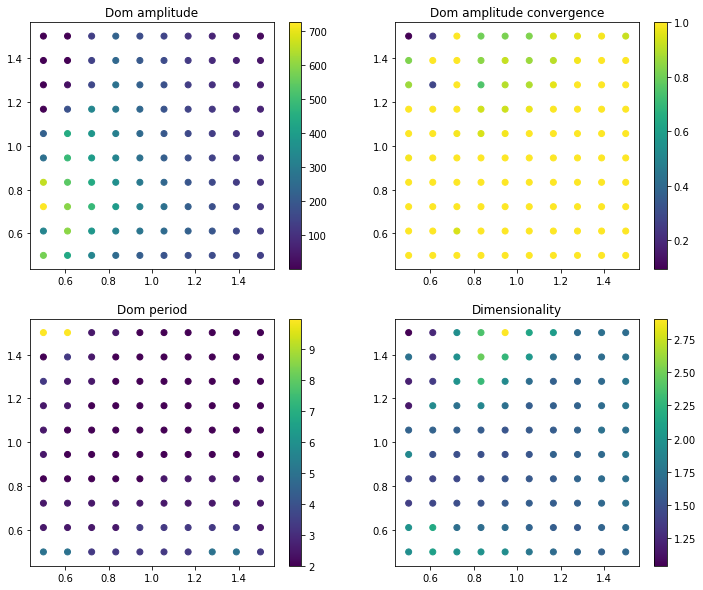

In [18]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(12, 10))

ax = axes[0][0]
ax.set_title("Dom amplitude")
im = ax.scatter(ggap_vals, gsyn_vals, c=dom_amplitude_vals)
fig.colorbar(im, ax=ax)
ax = axes[0][1]
ax.set_title("Dom amplitude convergence")
im = ax.scatter(ggap_vals, gsyn_vals, c=dom_amplitude_convergence_vals)
fig.colorbar(im, ax=ax)
ax = axes[1][0]
ax.set_title("Dom period")
im = ax.scatter(ggap_vals, gsyn_vals, c=dom_period_vals)
fig.colorbar(im, ax=ax)
ax = axes[1][1]
ax.set_title("Dimensionality")
im = ax.scatter(ggap_vals, gsyn_vals, c=dimensionality_vals)
_ = fig.colorbar(im, ax=ax)

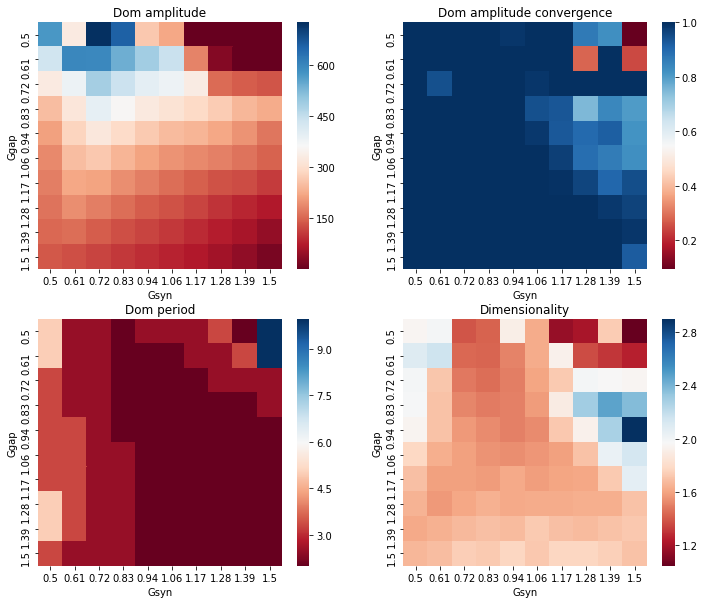

In [42]:
import seaborn as sns
import pandas as pd

def plot_heatmap(ax, ggap_vals, gsyn_vals, output_vals):
  ggap_vals = np.round(ggap_vals, 2)
  gsyn_vals = np.round(gsyn_vals, 2)
  df = pd.DataFrame.from_dict(np.array([ggap_vals,gsyn_vals,output_vals]).T)
  df.columns = ['Ggap','Gsyn','Output']
  df['Output'] = pd.to_numeric(df['Output'])
  pivotted = df.pivot('Ggap','Gsyn','Output')
  return sns.heatmap(pivotted,cmap='RdBu', ax = ax)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(12, 10))
ax = axes[0][0]
ax.set_title("Dom amplitude")
plot_heatmap(ax, ggap_vals, gsyn_vals, dom_amplitude_vals)
ax = axes[0][1]
ax.set_title("Dom amplitude convergence")
plot_heatmap(ax, ggap_vals, gsyn_vals, dom_amplitude_convergence_vals)
ax = axes[1][0]
ax.set_title("Dom period")
plot_heatmap(ax, ggap_vals, gsyn_vals, dom_period_vals)
ax = axes[1][1]
ax.set_title("Dimensionality")
plot_heatmap(ax, ggap_vals, gsyn_vals, dimensionality_vals)